In [1]:
import time
from typing import Final
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def runge_kutta(y0: np.ndarray, f: callable, t, **kwargs) -> np.ndarray:
    '''
        Функция численно находит решение для краевой задачи
        дифференциального уравнения методом Рунге Кутты

        :param y0: массив начальных условий y(0) и y'(0)
        :param f: функция, задающая дифференциальное уравнение
        :param t: массив значений переменной t
        :param args: параметры дифференциального уравнения

        :return: массив, содержащий значения y и y'
    '''
    # Вычисляем количество точек
    n = len(t)

    # Задаем массив, в котором будет храниться результат
    sol = np.zeros((n, len(y0)))

    # Кладем первые значения в массив результата
    sol[0] = y0

    # Запускаем основной цикл
    for i in range(n - 1):
        # Вычисляем шаг
        hop = t[i + 1] - t[i]

        with np.errstate(over='raise', invalid='raise'):
            try:
                # Вычисляем значения k1, k2, k3, k4
                k1 = f(sol[i], t[i], **kwargs)
                k2 = f(sol[i] + k1 * hop / 2., t[i] + hop / 2., **kwargs)
                k3 = f(sol[i] + k2 * hop / 2., t[i] + hop / 2., **kwargs)
                k4 = f(sol[i] + k3 * hop, t[i] + hop, **kwargs)
            except FloatingPointError as ex:
                raise ValueError(
                    'В процессе вычисления достигнута бесконечность'
                ) from ex

            # Находим значения y и y' на текущем шаге
            sol[i + 1] = sol[i] + (hop / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

        if sol[i + 1, 0] == np.nan or sol[i + 1, 1] == np.nan:
            return sol[:i + 1]
    return sol

In [4]:
def equation(x0: np.ndarray, t: np.ndarray, **kwargs) -> np.ndarray:
    """
        Функция задает дифференциальное уравнение

        x'' - mu * x' + x + a1 * x^2 + a2 * x * x' + a3 * x'^2 = 0

        В виде системы

        x' = y
        y' = mu * y - x - a1 * x^2 - a2 * x * y + a3 * y^2

        :param x0: Массив начальных условий x(0) и x'(0)
        :param t: Массив значений t
        :param args: Значения дифференциального уравнения

        :returns: Значения x' и x'' при заданных начальных условиях
    """
    x, y = x0

    mu = kwargs.get('mu', 0.0)
    a1 = kwargs.get('a1', 0.0)
    a2 = kwargs.get('a2', 0.0)
    a3 = kwargs.get('a3', 0.0)

    return np.array([
        y,
        mu * y - x - a1 * x ** 2 - a2 * x * y - a3 * y ** 2
    ])

In [5]:
# Шаг и допустимая погрешность для определения цикла.
HOP: Final = 1e-3
TOLERANCE: Final = 5e-4

def is_cycle(
    start_point: np.array,
    ode: callable,
    **kwargs
) -> bool:
    """
        Функция численно находит решение для краевой задачи
        дифференциального уравнения методом Рунге Кутты
        и определяет, является ли решение циклом.

        :param start_point: Точка, с которой необходимо начать
            построение траектории.
        :param ode: функция, задающая дифференциальное уравнение.
        :param kwargs: Параметры дифференциального уравнения.

        :return: Логическое значение, обозначающее является
            ли траектория циклом.
    """
    # Задаём шаг и допустимую погрешность
    hop, tolerance = 1e-2, 4e-4

    # Задаём две точки, с которыми мы будем оперировать
    current_point = np.copy(start_point)

    # Задаём переменную времени
    time_ = 0.0

    # Переменная обозначающая пересечение вертикальной оси
    is_intersected_x_left = False
    is_intersected_x_right = False

    # Массив различий в вертикальных координатах
    differences = np.array([])

    debug = kwargs.get('debug', False)

    # Основной цикл Рунге-Кутты
    while True:
        with np.errstate(over='raise', invalid='raise'):
            try:
                time_ += hop
                k1 = ode(current_point, time_, **kwargs)
                k2 = ode(
                    current_point + k1 * hop / 2.,
                    time_ + hop / 2.,
                    **kwargs
                )
                k3 = ode(
                    current_point + k2 * hop / 2.,
                    time_ + hop / 2.,
                    **kwargs
                )
                k4 = ode(current_point + k3 * hop, time_ + hop, **kwargs)
            except FloatingPointError:
                if debug:
                    print('Вышли за память')
                return False

            # Находим разницу между предыдущей и текущей точки
            difference = (hop / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

            # Находим текущее значение погрешности
            # Исходя из среднего значения разницы по всем итерациям
            absolute_vertical_difference = abs(difference[1])
            differences = np.append(differences, absolute_vertical_difference)
            tolerance = np.mean(differences)

            # Находим значения y и y' на текущем шаге
            current_point += difference

            # Если текущая точка в вычислениях правее стартовой
            #   Регистрируем событие, что траектория прошла вправо
            if current_point[1] > start_point[0]:
                is_intersected_x_right = True

            # Если текущая точка в вычислениях левее стартовой
            #   Регистрируем пересечение вертикальной оси
            if current_point[0] < start_point[0]:
                is_intersected_x_left = True

            # Формируем условия для положительного выхода из цикла
            # 1) Было пересечение с вертикальной осью
            # 2) По горизонтали расстояние от текущей точки
            #    до начальной меньше погрешности
            # 3) По вертикали расстояние от текущей точки
            #    до начальной меньше погрешности
            positive_conditions = [
                is_intersected_x_left,
                is_intersected_x_right,
                abs(start_point[0] - current_point[0]) <= tolerance,
                abs(start_point[1] - current_point[1]) <= tolerance
            ]

            # Если соблюдены условия для положительного выхода
            #   Возвращаем положительный результат
            if abs(start_point[0] - current_point[0]) <= tolerance and debug:
                print('Проверка была')
            if all(positive_conditions):
                if debug:
                    print(f'Погрешность: {tolerance}')
                    print(f'Разница между точками {abs(start_point[1] - current_point[1])}')
                return True

            # Формируем условия для положительного выхода из цикла
            # 1) Произошло пересечение вертикальной оси больше
            #    чем 1 раз.
            negative_conditions = [
                is_intersected_x_left and not is_intersected_x_right,
                is_intersected_x_left and is_intersected_x_right and \
                    current_point[0] > start_point[0]
            ]

            # Если соблюдены условия для негативного выхода
            #   Возвращаем негативный результат
            if any(negative_conditions):
                if debug:
                    print(f'Погрешность: {tolerance}')
                    print(f'Разница между точками: {abs(start_point[1] - current_point[1])}')
                return False

In [6]:
def process_one_batch(batch: list, start_x: float, **kwargs: dict) -> list:
    results = []
    for coordinate in batch:
        start_point = [start_x, coordinate]
        print(f'Поиск: {start_point}')
        result = is_cycle(start_point, equation, **kwargs)
        if result:
            results.append(start_point)
    return results

In [ ]:
mu = 0.1
a1 = 1.0
a2 = -1.0
a3 = 1.0

x = 0.0
y_range = np.arange(-1000, 1000, 0.0004)

START: Final = -10
FINISH: Final = 10
COUNT_BATCHES = 4

with ProcessPoolExecutor(max_workers=2) as executor:
    results = []
    futures = []
    for batch_number in range(COUNT_BATCHES):
        batch_size = (FINISH - START) / COUNT_BATCHES
        start = START + batch_size * batch_number
        finish =start + batch_size
        batch = np.arange(start, finish, 0.004).tolist()
        future = executor.submit(process_one_batch, batch, x, mu=mu, a1=a1, a2=a2, a3=a3)
        futures.append(future)

    for future in futures:
        results.extend(future.result())

print(results)

In [7]:
mu = 0.1
a1 = 1.0
a2 = -1.0
a3 = 1.0

x = 0.0
y_range = np.arange(-1, 1, 0.004)

for coordinate in y_range:
    x0 = [x, coordinate]
    result = is_cycle(x0, equation, mu=mu, a1=a1, a2=a2, a3=a3)
    if result:
        print(f'НАЙДЕН ЦИКЛ С КООРДИНАТАМИ ({x}, {coordinate})')

НАЙДЕН ЦИКЛ С КООРДИНАТАМИ (0.0, 0.30800000000000116)


In [197]:
# Тест-кейс на цикл
# x0 = np.array([-0.07480444, 0.31670763])
x0 = np.array([0.0, 0.308])

# Тест-кейс на цикл
# x0 = np.array([0.0, 0.001000000000000778])

# Тест-кейс на отсутствие цикла
# x0 = np.array([0.0, 0.01])

mu = 0.1
a1 = 1.0
a2 = -1.0
a3 = 1.0

start_time = time.time()
result = is_cycle(x0, equation, mu=mu, a1=a1, a2=a2, a3=a3, debug=True)
elapsed_time = time.time() - start_time
print(f'Результат: {result}, затрачено времени: {elapsed_time}')

Проверка была
Проверка была
Погрешность: 0.0017728876226968872
Разница между точками 0.0012024012287134012
Результат: True, затрачено времени: 0.1091148853302002


[]

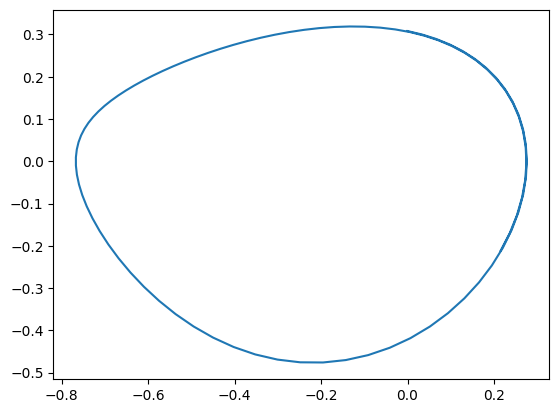

In [ ]:
x0 = np.array([0.0, 0.308])
mu = 0.1
a1 = 1.0
a2 = -1.0
a3 = 1.0

t1 = np.linspace(0, 11, 100)

second_sol = runge_kutta(
    x0,
    equation,
    t1,
    mu=mu,
    a1=a1,
    a2=a2,
    a3=a3
)

figure, second_axes = plt.subplots()
second_axes.plot(second_sol[:, 0], second_sol[:, 1])

plt.plot()